# Model Training, Evaluation, and Tuning
This notebook creates a model (Logistic Regression, Random Forest) for each feature set that we have (Demographic, Demographic + N-grams, Gemographioc + Mean Word Embedding). It first cleans up the data and formats it for training, then trains the models, and then evaluates them using cross-validation.

In [62]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [22]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import roc_curve, auc

# 1. Helper functions

In [3]:
# Performs k-fold cross-validation for a model.
def validate_model(m, X_train, t_train, fit_params={}, cv=5):
    cv_results = cross_validate(m, X_train, t_train, fit_params=fit_params,cv=cv, scoring=('accuracy'), return_train_score=True, verbose=10, n_jobs=-1)
    print("train accuracies: ", cv_results['train_score'])
    print("average train accuracies: ", np.mean(cv_results['train_score'] ))
    print("validation accuracies: ", cv_results['test_score'])
    print("average validation accuracies: ", np.mean(cv_results['test_score'] ))
    return cv_results

In [4]:
# Performs L1 feature selection using a Linear SVM
def L1_feature_select(X_train, X_test, Y_train, Y_test, C=0.01):
    lsvc = LinearSVC(C=C, penalty="l1", dual=False).fit(X_train, Y_train)
    model = SelectFromModel(lsvc, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print("old train shape: {}".format(X_train.shape))
    print("new train shape: {}".format(X_train_new.shape))
    return X_train_new, X_test_new

In [98]:
def grid_search_model(m, X_train, t_train, param_grid):
    clf = GridSearchCV(m, param_grid, cv=5, scoring='accuracy', n_jobs=16, return_train_score=True, verbose=10)
    clf.fit(X_train, t_train)
    params = clf.cv_results_['params']
    mean_train_scores = clf.cv_results_['mean_train_score']
    mean_test_scores = clf.cv_results_['mean_test_score']
    for i in range(len(params)):
        print("{}\n    mean_train_score: {}, mean_test_score: {}".format(params[i], mean_train_scores[i], mean_test_scores[i]))
    print("Best params: {}\n    mean_test_score: {}".format(clf.best_params_, clf.best_score_))
    return clf, clf.best_estimator_

In [99]:
def save_clf(name_val, val_res, name_clf, best_clf):
    pickle.dump(val_res, open("clfs/{}.p".format(name_val), "wb"))
    pickle.dump(best_clf, open("clfs/{}.p".format(name_clf), "wb"))

# 2. DEMOGRAPHIC DATA ONLY
## 2.1 Data Cleaning

In [72]:
# get merged justice and case data
jc_data = pd.read_pickle("demographic_approach/data/cases_justices_merged.pk")

In [6]:
jc_data

,justice,justiceName,justice_vote,petitionerState_1,petitionerState_10,petitionerState_12,petitionerState_13,petitionerState_15,petitionerState_17,petitionerState_18,...,undsch_103.0,undsch_104.0,undsch_110.0,undsch_111.0,undsch_112.0,undsch_113.0,undsch_114.0,undsch_115.0,undsch_116.0,undsch_117.0
44883,95,BRWhite,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44884,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44885,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44886,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44887,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44888,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44889,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44890,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44891,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44892,95,BRWhite,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Create X, Y data
X = jc_data.drop(columns = ["justice", "justiceName", "justice_vote"]).values.astype(np.float64)
Y = jc_data["justice_vote"].values.astype(np.int32)

In [48]:
# Normalize features
min_max_scaler = sklearn.preprocessing.StandardScaler()
X = min_max_scaler.fit_transform(X)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/anaconda3/lib/python3.6/site-packages/sklearn/utils/extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count


In [49]:
# Impute features
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)

In [50]:
# split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [46]:
np.save("nlp_approach/data/case_justices_merged_X_train.npy", X_train)
np.save("nlp_approach/data/case_justices_merged_X_test.npy", X_test)
np.save("nlp_approach/data/case_justices_merged_Y_train.npy", Y_train)
np.save("nlp_approach/data/case_justices_merged_Y_test.npy", Y_test)

## 2.2 Feature Selection using L1 Regularization

In [87]:
X_train_new, X_test_new = L1_feature_select(X_train, X_test, Y_train, Y_test)

old train shape: (35393, 1581)
new train shape: (35393, 611)


In [53]:
np.save("nlp_approach/data/case_justices_merged_X_train_new.npy", X_train_new)
np.save("nlp_approach/data/case_justices_merged_X_test_new.npy", X_test_new)

In [59]:
X_train_new = np.load("nlp_approach/data/case_justices_merged_X_train_new.npy")
X_test_new = np.load("nlp_approach/data/case_justices_merged_X_test_new.npy")
Y_train = np.load("nlp_approach/data/case_justices_merged_Y_train.npy")
Y_test = np.load("nlp_approach/data/case_justices_merged_Y_test.npy")

## 2.3 Logistic Regression Model

In [88]:
lr = LR()
cv_results = validate_model(lr, X_train_new, Y_train, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.6s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   48.6s remaining:   32.4s


train accuracies:  [0.64399237 0.64452214 0.64282687 0.64194391 0.64659556]
average train accuracies:  0.6439761729806548
validation accuracies:  [0.62424071 0.62664218 0.62904365 0.62296935 0.62893882]
average validation accuracies:  0.626366941026466


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


## 2.4 RandomForest Model

In [89]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
cv_results = validate_model(rf, X_train_new, Y_train, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.6s remaining:   33.0s


train accuracies:  [0.99173554 0.99251254 0.99141767 0.99177086 0.99184207]
average train accuracies:  0.9918557343777907
validation accuracies:  [0.7095635  0.70292414 0.70250035 0.7019353  0.69718807]
average validation accuracies:  0.7028222736586548


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


### 2.4.1 Hyperparameter Tuning

In [19]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 5, 10]

param_grid_1 = {
    "max_depth": max_depth
}

param_grid_2 = {
    "min_samples_split":min_samples_split
}

param_grid_3 = {
    "min_samples_leaf": min_samples_leaf
}

param_grid_4 = {
    "max_features": ["log2", "sqrt"]
}

In [16]:
# param grid 1: max_depth
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
validation_results_1, rf_best_1 = grid_search_model(rf, X_train_new, Y_train, param_grid_1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  30 | elapsed:   34.1s remaining:  5.1min
[Parallel(n_jobs=16)]: Done   7 out of  30 | elapsed:  3.9min remaining: 12.8min
[Parallel(n_jobs=16)]: Done  11 out of  30 | elapsed:  4.4min remaining:  7.5min
[Parallel(n_jobs=16)]: Done  15 out of  30 | elapsed:  4.5min remaining:  4.5min
[Parallel(n_jobs=16)]: Done  19 out of  30 | elapsed:  4.7min remaining:  2.7min
[Parallel(n_jobs=16)]: Done  23 out of  30 | elapsed:  6.6min remaining:  2.0min
[Parallel(n_jobs=16)]: Done  27 out of  30 | elapsed:  6.8min remaining:   45.3s
[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:  6.8min finished


{'max_depth': 10}
    mean_train_score: 0.6497259897065982, mean_test_score: 0.6220156528127031
{'max_depth': 35}
    mean_train_score: 0.89624362197851, mean_test_score: 0.6891193173791428
{'max_depth': 60}
    mean_train_score: 0.9730808460482658, mean_test_score: 0.696832707032464
{'max_depth': 85}
    mean_train_score: 0.9889172971285237, mean_test_score: 0.6970022320797898
{'max_depth': 110}
    mean_train_score: 0.9915166844824347, mean_test_score: 0.6958155567485096
{'max_depth': None}
    mean_train_score: 0.9918557343777907, mean_test_score: 0.6939790354024807
Best params: {'max_depth': 85}
    mean_test_score: 0.6970022320797898


In [20]:
# param grid 2: min_samples_split
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_depth=85)
validation_results_2, rf_best_2 = grid_search_model(rf, X_train_new, Y_train, param_grid_2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  15 | elapsed:  1.2min remaining:  8.1min
[Parallel(n_jobs=16)]: Done   4 out of  15 | elapsed:  1.3min remaining:  3.5min
[Parallel(n_jobs=16)]: Done   6 out of  15 | elapsed:  3.5min remaining:  5.2min
[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  3.6min remaining:  3.1min
[Parallel(n_jobs=16)]: Done  10 out of  15 | elapsed:  3.6min remaining:  1.8min
[Parallel(n_jobs=16)]: Done  12 out of  15 | elapsed:  3.6min remaining:   53.9s
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  3.6min finished


{'min_samples_split': 2}
    mean_train_score: 0.9889314338947699, mean_test_score: 0.6977085864436471
{'min_samples_split': 5}
    mean_train_score: 0.9614047816625224, mean_test_score: 0.7038679964964824
{'min_samples_split': 10}
    mean_train_score: 0.9363857288339432, mean_test_score: 0.699742887011556
Best params: {'min_samples_split': 5}
    mean_test_score: 0.7038679964964824


In [21]:
# param grid 3: min_samples_leaf
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_depth=85, min_samples_split=5)
validation_results_3, rf_best_3 = grid_search_model(rf, X_train_new, Y_train, param_grid_3)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  15 | elapsed:  1.2min remaining:  7.6min
[Parallel(n_jobs=16)]: Done   4 out of  15 | elapsed:  1.2min remaining:  3.3min
[Parallel(n_jobs=16)]: Done   6 out of  15 | elapsed:  2.9min remaining:  4.3min
[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  2.9min remaining:  2.6min
[Parallel(n_jobs=16)]: Done  10 out of  15 | elapsed:  2.9min remaining:  1.5min
[Parallel(n_jobs=16)]: Done  12 out of  15 | elapsed:  3.0min remaining:   44.8s
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  3.0min finished


{'min_samples_leaf': 1}
    mean_train_score: 0.9610445403379689, mean_test_score: 0.7044330799875682
{'min_samples_leaf': 5}
    mean_train_score: 0.7395388837804946, mean_test_score: 0.6638600853276072
{'min_samples_leaf': 10}
    mean_train_score: 0.6795553123642607, mean_test_score: 0.6405503913203175
Best params: {'min_samples_leaf': 1}
    mean_test_score: 0.7044330799875682


In [25]:
# param grid 4: max_features
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_depth=85, min_samples_leaf=1, min_samples_split=5)
validation_results_4, rf_best = grid_search_model(rf, X_train_new, Y_train, param_grid_4)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=16)]: Done   5 out of  10 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=16)]: Done   7 out of  10 | elapsed:  2.1min remaining:   53.6s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:  2.1min finished


{'max_features': 'log2'}
    mean_train_score: 0.9480052361763954, mean_test_score: 0.7026530669906479
{'max_features': 'sqrt'}
    mean_train_score: 0.9610021859177491, mean_test_score: 0.7024835419433221
Best params: {'max_features': 'log2'}
    mean_test_score: 0.7026530669906479


In [27]:
save_clf("validation_results_rf", validation_results_4, "rf_best", rf_best)

### 2.4.2 Testing

In [67]:
rf_best = RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, 
                                 max_depth=85, min_samples_leaf=1, min_samples_split=5, max_features="log2")
rf_best.fit(X_train_new, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=85, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [62]:
test_score = rf_best.score(X_test_new, Y_test)
print("Test Accuracy: {}".format(test_score))

Test Accuracy: 0.7227935359927675


In [65]:
rf_best.fit(X_train_new, Y_train)
cv_results_rf = validate_model(rf_best, X_train_new, Y_train, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   37.8s remaining:   25.2s


train accuracies:  [0.94801158 0.94868263 0.94652822 0.94755245 0.94999294]
average train accuracies:  0.9481535637078922
validation accuracies:  [0.70560814 0.71281254 0.7030654  0.70800961 0.71004663]
average validation accuracies:  0.7079084642819566


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.7s finished


### 2.4.3 ROC curve and AUC

In [69]:
Y_pred = rf_best.predict(X_test_new)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7213913082497496

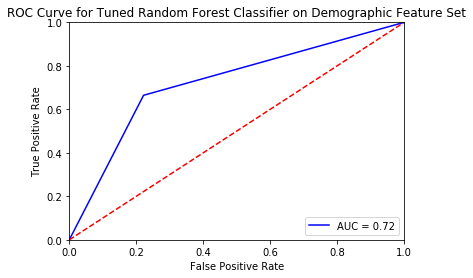

<Figure size 432x288 with 0 Axes>

In [71]:
# Source: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.title('ROC Curve for Tuned Random Forest Classifier on Demographic Feature Set')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("clfs/roc_curve_rf.png")
plt.show()

# 3. DEMOGRAPHIC DATA + N-GRAMS
## 1-grams
## 3.1 Data cleaning

In [55]:
# 1-gram data. Note that imputing the data was already done in pre-processing.
Y_1gram = np.load("nlp_approach/data/case_justices_1grams_merged_Y.npy")
X_1gram = np.load("nlp_approach/data/case_justices_1grams_merged_X.npy")

In [56]:
X_train_1gram, X_test_1gram, Y_train_1gram, Y_test_1gram = train_test_split(X_1gram, Y_1gram, test_size=0.2, random_state=42)

In [57]:
np.save("nlp_approach/data/case_justices_1grams_merged_X_train.npy", X_train_1gram)
np.save("nlp_approach/data/case_justices_1grams_merged_X_test.npy", X_test_1gram)
np.save("nlp_approach/data/case_justices_1grams_merged_Y_train.npy", Y_train_1gram)
np.save("nlp_approach/data/case_justices_1grams_merged_Y_test.npy", Y_test_1gram)

## 3.2 Feature Section using L1-Regularization

In [58]:
X_train_1gram_new, X_test_1gram_new = L1_feature_select(X_train_1gram, X_test_1gram, Y_train_1gram, Y_test_1gram, C=0.1)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


old train shape: (35393, 6581)
new train shape: (35393, 568)


In [59]:
np.save("nlp_approach/data/case_justices_1grams_merged_X_train_new.npy", X_train_1gram_new)
np.save("nlp_approach/data/case_justices_1grams_merged_X_test_new.npy", X_test_1gram_new)

In [68]:
X_train_1gram_new = np.load("nlp_approach/data/case_justices_1grams_merged_X_train_new.npy")
X_test_1gram_new = np.load("nlp_approach/data/case_justices_1grams_merged_X_test_new.npy")
Y_train_1gram = np.load("nlp_approach/data/case_justices_1grams_merged_Y_train.npy")
Y_test_1gram = np.load("nlp_approach/data/case_justices_1grams_merged_Y_test.npy")

## 3.3 Logistic Regression Model

In [60]:
lr = LR()
cv_results = validate_model(lr, X_train_1gram_new, Y_train_1gram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   45.9s remaining:   30.6s


train accuracies:  [0.64137882 0.64102564 0.64130819 0.64236773 0.64384094]
average train accuracies:  0.6419842644495588
validation accuracies:  [0.62395819 0.63116259 0.63201017 0.62876112 0.62724318]
average validation accuracies:  0.6286270514582364


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.6s finished


### 3.3.1 Hyperparameter Tuning

In [45]:
param_grid_C = {"C": [0.1,1,10,100]}

In [50]:
lr = LR()
validation_results_lr, lr_best = grid_search_model(lr, X_train_1gram_new, Y_train_1gram, param_grid_C)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 out of  20 | elapsed:  1.6min remaining:  6.6min
[Parallel(n_jobs=16)]: Done   7 out of  20 | elapsed:  5.5min remaining: 10.3min
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:  5.9min remaining:  5.9min
[Parallel(n_jobs=16)]: Done  13 out of  20 | elapsed:  6.3min remaining:  3.4min
[Parallel(n_jobs=16)]: Done  16 out of  20 | elapsed:  6.8min remaining:  1.7min
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:  7.1min finished
/usr/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 0.1}
    mean_train_score: 0.6365453498131457, mean_test_score: 0.6219873986381488
{'C': 1}
    mean_train_score: 0.6421114075366731, mean_test_score: 0.6291639589749386
{'C': 10}
    mean_train_score: 0.6418429845961983, mean_test_score: 0.6282880795637555
{'C': 100}
    mean_train_score: 0.6417794083129454, mean_test_score: 0.6285141129601899
Best params: {'C': 1}
    mean_test_score: 0.6291639589749386


In [51]:
save_clf("validation_results_lr", validation_results_lr, "lr_best", lr_best)

### 3.3.2 Testing

In [73]:
lr_best = LR(C=1)
lr_best.fit(X_train_1gram_new, Y_train_1gram)

/usr/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
test_score = lr_best.score(X_test_1gram_new, Y_test_1gram)
print("Test Accuracy: {}".format(test_score))

Test Accuracy: 0.6249293705503447


In [55]:
cv_results = validate_model(lr_best, X_train_1gram_new, Y_train_1gram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   45.3s


train accuracies:  [0.64169669 0.64063714 0.64180264 0.64240305 0.64401752]
average train accuracies:  0.6421114075366731
validation accuracies:  [0.62480576 0.63243396 0.63158638 0.63017375 0.62681927]
average validation accuracies:  0.6291638264881313


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


### 3.3.3 ROC curve and AUC

In [76]:
Y_pred_1gram = lr_best.predict(X_test_1gram_new)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test_1gram, Y_pred_1gram)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6222056091789917

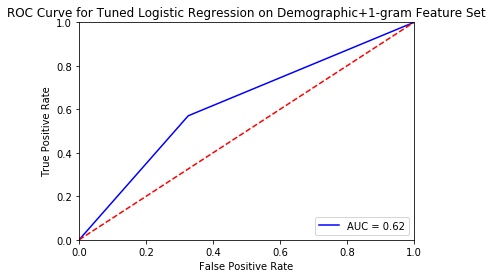

In [78]:
# Source: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
plt.title('ROC Curve for Tuned Logistic Regression on Demographic+1-gram Feature Set')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("clfs/roc_curve_lr.png")
plt.show()

## 3.4 Random Forest Model

In [61]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
cv_results = validate_model(rf, X_train_1gram_new, Y_train_1gram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.4s remaining:   50.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.8s remaining:   22.5s


train accuracies:  [0.99085258 0.99155895 0.9904994  0.99092322 0.9907826 ]
average train accuracies:  0.9909233484128499
validation accuracies:  [0.63935584 0.64952677 0.63864953 0.63893205 0.64278649]
average validation accuracies:  0.6418501362617008


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.2s finished


## N-grams (1 to 5 )

## 3.1 Data cleaning

In [23]:
ngram_features = np.load("nlp_approach/data/ngrams/1to5grams_names.p")
ngram_features

['000',
 '10',
 '10 years',
 '100',
 '10th',
 '10th amendment',
 '11',
 '12',
 '12 years',
 '13',
 '14',
 '14th',
 '14th amendment',
 '15',
 '15 years',
 '150',
 '17',
 '1787',
 '18',
 '1948',
 '1954',
 '1960',
 '1961',
 '1964',
 '1965',
 '1966',
 '1968',
 '1969',
 '1970',
 '1971',
 '1973',
 '1974',
 '1975',
 '1976',
 '1980',
 '1983',
 '1985',
 '1992',
 '19th',
 '19th century',
 '20',
 '20 years',
 '20 years ago',
 '200',
 '200 years',
 '200 years ago',
 '21',
 '23',
 '23 years',
 '24',
 '24 years',
 '25',
 '25 years',
 '28',
 '2d',
 '30',
 '30 years',
 '40',
 '50',
 '50 years',
 '632',
 '70',
 '700',
 '78',
 '80',
 '90',
 '97',
 'aba',
 'abide',
 'abilities',
 'ability',
 'able',
 'abortion',
 'abortions',
 'absence',
 'absolute',
 'absolutely',
 'absolutely right',
 'absolutely senator',
 'abstract',
 'abuse',
 'abused',
 'aca',
 'academic',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'access',
 'accommodation',
 'accordance',
 'according',
 'according law',
 'according ru

In [22]:
# 1-gram data. Note that imputing the data was already done in pre-processing.
Y_ngram = np.load("nlp_approach/data/case_justices_1to5grams_merged_Y.npy")
X_ngram = np.load("nlp_approach/data/case_justices_1to5grams_merged_X.npy")

In [24]:
X_train_ngram, X_test_ngram, Y_train_ngram, Y_test_ngram = train_test_split(X_ngram, Y_ngram, test_size=0.2, random_state=42)


In [25]:
np.save("nlp_approach/data/case_justices_ngrams_merged_X_train.npy", X_train_ngram)
np.save("nlp_approach/data/case_justices_ngrams_merged_X_test.npy", X_test_ngram)
np.save("nlp_approach/data/case_justices_ngrams_merged_Y_train.npy", Y_train_ngram)
np.save("nlp_approach/data/case_justices_ngrams_merged_Y_test.npy", Y_test_ngram)

## 3.2 Feature Section using L1-Regularization

In [26]:
X_train_ngram_new, X_test_ngram_new = L1_feature_select(X_train_ngram, X_test_ngram, Y_train_ngram, Y_test_ngram, C=0.1)


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


old train shape: (35393, 6581)
new train shape: (35393, 568)


In [73]:
np.save("nlp_approach/data/case_justices_ngrams_merged_X_train_new.npy", X_train_ngram_new)
np.save("nlp_approach/data/case_justices_ngrams_merged_X_test_new.npy", X_test_ngram_new)

## 3.3 Logistic Regression Model

In [44]:
lr = LR()
cv_results = validate_model(lr, X_train_ngram_new, Y_train_ngram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.1s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   42.2s remaining:   28.1s


train accuracies:  [0.64049587 0.63993078 0.63925973 0.64183796 0.64451194]
average train accuracies:  0.6412072541931664
validation accuracies:  [0.62551208 0.63314027 0.63299901 0.62791355 0.62286279]
average validation accuracies:  0.6284855410535368


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   56.1s finished


## 3.4 Random Forest Model

In [45]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
cv_results = validate_model(rf, X_train_ngram_new, Y_train_ngram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   29.7s remaining:   44.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   30.0s remaining:   20.0s


train accuracies:  [0.99064067 0.99162958 0.99046408 0.99085258 0.9905707 ]
average train accuracies:  0.9908315240417875
validation accuracies:  [0.64726656 0.6471253  0.6372369  0.63398785 0.64038434]
average validation accuracies:  0.6412001912328662


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s finished


## with IDF Transform

In [30]:
X_ngram_idf = np.load("nlp_approach/data/case_justices_1to5grams_merged_X_idf.npy")

In [31]:
X_train_ngram_idf, X_test_ngram_idf, Y_train_ngram, Y_test_ngram = train_test_split(X_ngram_idf, Y_ngram, test_size=0.2, random_state=42)


In [32]:
np.save("nlp_approach/data/case_justices_ngrams_merged_X_train_idf.npy", X_train_ngram_idf)
np.save("nlp_approach/data/case_justices_ngrams_merged_X_test_idf.npy", X_test_ngram_idf)

## 3.2 Feature Section using L1-Regularization

In [39]:
X_train_ngram_idf_new, X_test_ngram_idf_new = L1_feature_select(X_train_ngram_idf, X_test_ngram_idf, Y_train_ngram, Y_test_ngram, C=1)


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


old train shape: (35393, 6581)
new train shape: (35393, 686)


In [41]:
np.save("nlp_approach/data/case_justices_ngrams_merged_X_train_idf_new.npy", X_train_ngram_idf_new)
np.save("nlp_approach/data/case_justices_ngrams_merged_X_test_idf_new.npy", X_test_ngram_idf_new)

## 3.3 Logistic Regression Model

In [40]:
lr = LR()
cv_results = validate_model(lr, X_train_ngram_idf_new, Y_train_ngram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.3s remaining:   32.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.9s remaining:   14.6s


train accuracies:  [0.64328601 0.64413364 0.64332133 0.64166137 0.64161605]
average train accuracies:  0.6428036785187897
validation accuracies:  [0.6197203  0.62763102 0.6284786  0.62254556 0.61975413]
average validation accuracies:  0.6236259219739007


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


## 3.4 Random Forest Model

In [42]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
cv_results = validate_model(rf, X_train_ngram_idf_new, Y_train_ngram, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.9s remaining:   59.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   40.5s remaining:   27.0s


train accuracies:  [0.99219467 0.99300699 0.99187681 0.99222999 0.99226586]
average train accuracies:  0.9923148652135797
validation accuracies:  [0.65715497 0.64316994 0.64882045 0.65305834 0.65394941]
average validation accuracies:  0.6512306229362109


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.7s finished


## Accuracy Results

|  | Training Accuracy | Validation Accuracy |
|----------------------------------------|-------------------|---------------------|
| Baseline (guess defendant) | 0.531 | 0.531 |
| LR (Demographic) | 0.644 | 0.626 |
| LR (Demographic, 1-grams) | 0.642 | 0.629 |
| LR (Demographic, 1 to 5-grams) | 0.641 | 0.628 |
| LR (Demographic, 1 to 5-grams, TF-IDF) | 0.643 | 0.624 |
| RF (Demographic) | 0.992 | 0.703 |
| RF (Demographic, 1-grams) | 0.991 | 0.643 |
| RF (Demographic, 1 to 5-grams) | 0.991 | 0.641 |
| RF (Demographic, 1 to 5-grams, TF-IDF) | 0.991 | 0.651 |
| RF (Past Votes) | 0.996 | 0.724 |

# 4. DEMOGRAPHIC + MEAN EMBEDDING

## 4.1 Data cleaning

In [73]:
mean_embeddings = np.load("mean_embeddings.npy")

In [74]:
# convert mean word embeddings into a dataframe
justicenames = ['AJGoldberg', 'AMKennedy', 'AScalia', 'BRWhite', 'DHSouter', 'EKagan', 'JGRoberts', 'JPStevens', 'LFPowell', 'NMGorsuch', 'RBGinsburg', 'SAAlito', 'SDOConnor', 'SGBreyer', 'SSotomayor', 'TMarshall', 'WHRehnquist']
emb_df = pd.DataFrame(data=np.array(mean_embeddings).T, columns=justicenames)
emb_df = emb_df.T
emb_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
AJGoldberg,0.008152,0.030855,0.049433,0.099664,-0.068314,-0.044576,0.054488,-0.046819,0.087485,0.026701,...,-0.085280,0.002186,-0.045725,0.010782,-0.040817,-0.002206,0.017133,-0.044007,0.024941,0.017669
AMKennedy,0.016872,0.033430,0.032639,0.100741,-0.055972,-0.030286,0.086012,-0.031739,0.097141,0.037108,...,-0.070913,0.002739,-0.030951,-0.004130,-0.028663,0.016892,0.026093,-0.060026,0.041306,-0.007428
AScalia,0.022761,0.024507,0.030656,0.103310,-0.064888,-0.022084,0.088640,-0.033492,0.107173,0.039799,...,-0.068686,0.017412,-0.030655,0.001107,-0.034818,0.004451,0.027409,-0.060654,0.038389,-0.004057
BRWhite,0.011146,0.046047,0.040470,0.097818,-0.038411,-0.063352,0.048497,-0.045905,0.095829,0.048845,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
DHSouter,0.025509,0.034823,0.031487,0.098700,-0.062366,-0.023857,0.088676,-0.042049,0.103281,0.047648,...,-0.072291,0.015554,-0.037238,0.005705,-0.029011,0.012824,0.021722,-0.058771,0.029084,-0.011395
EKagan,0.019558,0.038979,0.030725,0.107536,-0.054141,-0.035241,0.081142,-0.029598,0.095316,0.032488,...,-0.070401,0.007380,-0.036783,-0.005863,-0.039308,0.011736,0.030312,-0.057283,0.042815,-0.001315
JGRoberts,0.016157,0.041639,0.028075,0.102392,-0.052291,-0.027871,0.084310,-0.037156,0.101411,0.038104,...,-0.061336,0.003481,-0.024413,-0.000453,-0.028761,0.014732,0.032057,-0.062147,0.037187,-0.002238
JPStevens,0.025139,0.030309,0.023600,0.096372,-0.061139,-0.020110,0.091802,-0.039671,0.110155,0.039653,...,-0.069516,0.012484,-0.028121,0.006008,-0.026353,0.013316,0.029625,-0.065233,0.027977,-0.011153
LFPowell,0.015467,0.036296,0.037268,0.091282,-0.063734,-0.027750,0.070568,-0.036367,0.098408,0.032488,...,-0.078713,0.001923,-0.038970,0.016924,-0.024185,0.003162,0.013345,-0.070291,0.035007,-0.007677
NMGorsuch,0.027357,0.032483,0.031983,0.103614,-0.048414,-0.028371,0.072933,-0.031878,0.093986,0.048350,...,-0.055399,0.010445,-0.053723,-0.012857,-0.028771,0.005119,0.028553,-0.064721,0.042943,-0.001579


In [75]:
# merge mean word embeddings with justice and case data
emb_df["justiceName"] = emb_df.index
merged_jc_emb = jc_data.merge(emb_df, on='justiceName')
merged_jc_emb

,justice,justiceName,justice_vote,petitionerState_1,petitionerState_10,petitionerState_12,petitionerState_13,petitionerState_15,petitionerState_17,petitionerState_18,...,290,291,292,293,294,295,296,297,298,299
0,95,BRWhite,1,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
1,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
2,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
3,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
4,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
5,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
6,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
7,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
8,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462
9,95,BRWhite,0,0,0,0,0,0,0,0,...,-0.066685,-0.022377,-0.033402,-0.016695,-0.011504,0.010424,0.007548,-0.080530,0.042416,0.017462


In [77]:
# create data and labels
X_emb = merged_jc_emb.drop(columns = ["justice", "justiceName", "justice_vote"]).values.astype(np.float64)
Y_emb = merged_jc_emb["justice_vote"].values.astype(np.int32)

# impute missing values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_emb)
X_emb = imp.transform(X_emb)

In [86]:
np.save("nlp_approach/data/mean_embedding/cases_justices_emb_merged_X.npy", X_emb)
np.save("nlp_approach/data/mean_embedding/cases_justices_emb_merged_Y.npy", Y_emb)

In [78]:
# split in to training and test data
X_train_emb, X_test_emb, Y_train_emb, Y_test_emb = train_test_split(X_emb, Y_emb, test_size=0.2, random_state=42)


## 4.2 Feature Selection using L1 Regularization

In [79]:
X_train_emb_new, X_test_emb_new = L1_feature_select(X_train_emb, X_test_emb, Y_train_emb, Y_test_emb, C=0.1)


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


old train shape: (35393, 1881)
new train shape: (35393, 457)


## 4.3 Logistic Regression Model

In [80]:
# with L1 regularization feature selection
lr = LR()
cv_results = validate_model(lr, X_train_emb_new, Y_train_emb, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.3s remaining:    7.5s


train accuracies:  [0.64077841 0.64077841 0.64109628 0.64194391 0.64366436]
average train accuracies:  0.6416522757030532
validation accuracies:  [0.62395819 0.63172765 0.63017375 0.62522955 0.62710188]
average validation accuracies:  0.6276382032422279


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


In [85]:
# without L1 regularization feature selection
lr = LR()
cv_results = validate_model(lr, X_train_emb, Y_train_emb, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.1min remaining:  1.4min


train accuracies:  [0.64204987 0.64275623 0.64356855 0.64233242 0.64716062]
average train accuracies:  0.6435735373226544
validation accuracies:  [0.62070914 0.62748976 0.62522955 0.61887272 0.62342801]
average validation accuracies:  0.6231458357398625


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


## 4.4 Random Forest Model

In [81]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
cv_results = validate_model(rf, X_train_emb_new, Y_train_emb, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.0s remaining:   40.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   27.2s remaining:   18.1s


train accuracies:  [0.99095854 0.9916649  0.99074663 0.99120576 0.99095918]
average train accuracies:  0.9911070006473824
validation accuracies:  [0.65715497 0.66676084 0.65574234 0.65235203 0.66030804]
average validation accuracies:  0.6584636422116191


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.3s finished


## For debugging purposes

In [47]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('Y_train', 141668),
 ('Y_train_1gram', 141668),
 ('Y_pred', 35492),
 ('Y_test', 35492),
 ('Y_test_1gram', 35492),
 ('GridSearchCV', 1464),
 ('LR', 1464),
 ('LinearSVC', 1056),
 ('SelectFromModel', 1056),
 ('SimpleImputer', 1056),
 ('TfidfTransformer', 1056),
 ('NamespaceMagics', 888),
 ('RandomForestClassifier', 888),
 ('param_grid_1', 240),
 ('param_grid_2', 240),
 ('param_grid_3', 240),
 ('param_grid_4', 240),
 ('param_grid_C', 240),
 ('L1_feature_select', 136),
 ('auc', 136),
 ('cross_validate', 136),
 ('grid_search_model', 136),
 ('roc_curve', 136),
 ('save_clf', 136),
 ('train_test_split', 136),
 ('validate_model', 136),
 ('max_depth', 128),
 ('false_positive_rate', 120),
 ('true_positive_rate', 120),
 ('X_test_1gram_new', 112),
 ('X_test_new', 112),
 ('X_train_1gram_new', 112),
 ('X_train_new', 112),
 ('mean_test_scores', 112),
 ('mean_train_scores', 112),
 ('thresholds', 108),
 ('params', 104),
 ('sorted_validation_scores', 104),
 ('min_samples_leaf', 88),
 ('min_samples_split